# Variational Autoencoder

In [ ]:
# check Pillow version
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [ ]:
import os

directory = '/content/results/'
if not os.path.exists(directory):
  os.makedirs(directory)

In [ ]:
! pip3 install torch torchvision
! pip3 install pillow

    100% |████████████████████████████████| 61kB 2.0MB/s 


In [ ]:
import numpy as np
import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

## Variational Autoencoder
Please remember the training objective (ELBO) from the slides:
$$
 \underbrace{
  \mathbb{E}_{z \sim q_\phi(z|x)} \big[ \log p_{\theta(x \,|\, z)}  \big]
}_{-\frac{1}{2} ||x - \hat{x}) ||^2 \, + \, C} 
-
\underbrace{
    D_{KL}\big[q_{\phi}( z \,|\, x) \,||\, p(z)\big]
}_{
\frac{1}{2} \sum_{i=1}^k 
  \big( 
    \sigma^2_i + \mu_i^2 - \log \sigma^2_i - 1
  \big)
}
$$ that we wan't to maximize. PyTorch optimizers are designed for gradient *descent*, so please modify the training loss accordingly.

## Vanilla VAE

In [ ]:
def reconstruction_loss(x, y):
    ''' 
    Implements the reconstruction losss
    '''
    return 0.5 * torch.sum(torch.pow(x - y.view(y.size(0), -1), 2)) / x.size(0)
  
    # If you use BCE you'll end up with a Bernoulli distributed generator
    # return F.binary_cross_entropy(x, y, reduction="sum") / x.size(0)


def kl_loss(mu, log_var):
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_div = kl_div / mu.size(0)  # mean over batch
    
    return kl_div
  

def reparameterize(mu, log_var):
    '''
    Note: one common trick is to force the inference network to output
    the logarithm of variance, as its range all real numbers 
    '''  

    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return mu + std*eps

In [ ]:
class VAE(nn.Module):
    '''
    On Mnist
    '''
    def __init__(self, 
                 feature_size: int = 784,
                 hidden_size: int = 400,
                 code_size: int = 20):
        super(VAE, self).__init__()
        self.code_size = code_size
        self.feature_size = feature_size

        self.encoder = nn.Sequential(
            nn.Linear(feature_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, code_size * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(code_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, feature_size),
            nn.Sigmoid()
        )


    def forward(self, x):
      x = x.view(-1, self.feature_size)

      # split the activations from the inference network in two
      mu, log_var = self.encoder(x).chunk(2, dim=1)

      z = reparameterize(mu, log_var)

      return self.decoder(z), kl_loss(mu, log_var)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import Tuple, List

def plot_losses(total_losses, rec_losses, kl_losses, phase):
  fig, ax = plt.subplots()
  plt.plot(np.array(kl_losses), label='KL')
  plt.plot(np.array(rec_losses), label='Reconstruction loss')
  plt.plot(np.array(total_losses), label='ELBO')
  plt.title(f"Losses: {phase}")
  plt.legend()
  plt.show()
  


def update(new: Tuple[List], old: Tuple[List]) -> Tuple[List]:
    '''
    Helper function to update training history
    '''
    for new_list, old_list in zip(new, old):
        old_list.extend(new_list)
        
    return old

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, test_loader,
                 log_interval: int =10,
                 batch_size: int =128):
      self.model = model
      self.train_loader = train_loader
      self.test_loader = train_loader

      self.log_interval = log_interval
      self.batch_size = batch_size
      
      self.optimizer = optim.Adam(model.parameters(), lr=1e-3)

    def train(self, epoch):
        self.model.train()
        train_loss = 0
        
        losses, recon_losses, kl_divs = [], [], []
        for batch_idx, (data, _) in enumerate(self.train_loader):
            data = data.to(device)
            self.optimizer.zero_grad()
            
            recon_batch, kl_div = self.model(data)
            recon_loss = reconstruction_loss(recon_batch, data)
            loss =  recon_loss + kl_div
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()

            if batch_idx % self.log_interval == 0:
                losses.append(loss.item() / len(data))
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), losses[-1]
                    ))
                
                recon_losses.append(recon_loss.item() / len(data))
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tRecon: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), recon_losses[-1]
                    ))
                
                kl_divs.append(kl_div.item() / len(data))
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tKL: {:.6f}\n'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), kl_divs[-1]
                    ))
                
                
                

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))
        
        return losses, recon_losses, kl_divs


    def test(self, epoch, fixed_sample = None):
        self.model.eval()
        test_loss = 0
        losses, recon_losses, kl_divs = [], [], []
        
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(self.test_loader):
                data = data.to(device)                
                recon_batch, kl_div = self.model(data)
                recon_loss = reconstruction_loss(recon_batch, data)
                loss = recon_loss + kl_div
                test_loss += loss.item()
                
                
                if batch_idx == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([
                        data[:n],
                        recon_batch.view(self.batch_size, 1, 28, 28)[:n]
                    ])
                    
                    save_image(comparison.cpu(),
                             f'/content/results/reconstruction_{epoch:03d}.png', nrow=n)
            
                if batch_idx % self.log_interval == 0:
                    losses.append(loss.item() / len(data))
                    recon_losses.append(recon_loss.item() / len(data))
                    kl_divs.append(kl_div.item() / len(data))
              
            if not fixed_sample is None:
                fixed_sample = fixed_sample.to(device)
                recon_sample = self.model.decoder(fixed_sample)
                recon_sample = recon_sample.view(-1, 1, 28, 28).cpu()
                
                sample_name = f'/content/results/fixed_reconstruction_{epoch:03d}.png'
                save_image(recon_sample, sample_name)   
              

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        return losses, recon_losses, kl_divs
        
      
    def run(self, num_epochs, fixed_sample = None):
        train_losses, test_losses = ([],[],[]), ([], [], [])

        for epoch in range(1, num_epochs + 1):
            update(self.train(epoch), train_losses) 
            update(self.test(epoch, fixed_sample), test_losses)
           
            with torch.no_grad():
                sample = torch.randn(64, model.code_size).to(device)
                sample = model.decoder(sample).cpu()
                sample_name = f"results/sample_{epoch}.png"
                save_image(sample.view(64, 1, 28, 28), sample_name)
              
        return train_losses, test_losses

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

Processing...
Done!


In [ ]:
# you can try different sizes
code_size = 64 

model = VAE(code_size=code_size)
model.to(device)

trainer = Trainer(
    model = model, 
    train_loader = train_loader,
    test_loader = test_loader,
    log_interval = 100
)

In [ ]:
train_losses, test_losses = trainer.run(
    5, fixed_sample=torch.randn(32, model.code_size)
)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.717041
Train Epoch: 1 [0/60000 (0%)]	Recon: 0.714796
Train Epoch: 1 [0/60000 (0%)]	KL: 0.002245

Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.211433
Train Epoch: 1 [12800/60000 (21%)]	Recon: 0.206775
Train Epoch: 1 [12800/60000 (21%)]	KL: 0.004658

Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.201599
Train Epoch: 1 [25600/60000 (43%)]	Recon: 0.187654
Train Epoch: 1 [25600/60000 (43%)]	KL: 0.013945

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.189349
Train Epoch: 1 [38400/60000 (64%)]	Recon: 0.168776
Train Epoch: 1 [38400/60000 (64%)]	KL: 0.020573

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.185066
Train Epoch: 1 [51200/60000 (85%)]	Recon: 0.158294
Train Epoch: 1 [51200/60000 (85%)]	KL: 0.026771

====> Epoch: 1 Average loss: 0.2044
====> Test set loss: 1.1053
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.172335
Train Epoch: 2 [0/60000 (0%)]	Recon: 0.145940
Train Epoch: 2 [0/60000 (0%)]	KL: 0.026395

Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.176094
Train Epoch: 2 [

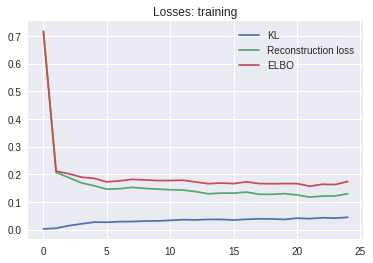

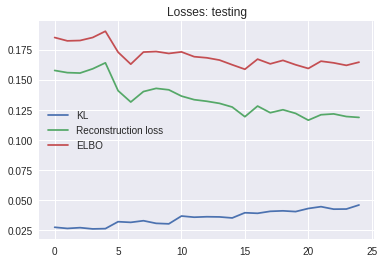

In [ ]:
plot_losses(*train_losses, 'training')
plot_losses(*test_losses, 'testing')

In [ ]:
# Save images from training data
import imageio
import glob

img_path = '/content/results/'
img_tmp = 'fixed_reconstruction*.png'

images = [
    imageio.imread(f) for f in sorted(glob.glob(f"{img_path}/{img_tmp}"))
]

imageio.mimsave(f"{img_path}/training.gif", images, duration=0.2)